Mounted at /content/drive
Using device: /GPU:0
Extracting features with batched processing...
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step
Feature extraction took 40.87 seconds
Applying Random Oversampling...
Splitting data...
Computed alpha values: [np.float64(0.13472376761969088), np.float64(0.08570947862186559), np.float64(0.04008614377765143), np.float64(0.38308410444903407), np.float64(0.03958191555403317), np.float64(0.006570420881676199), np.float64(0.3102441690960487)]
Training full model...
Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.1585 - loss: 0.2595 - val_accuracy: 0.1760 - val_loss: 0.2438 - learning_rate: 1.0000e-05
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 565ms/step - accuracy: 0.1984 - loss: 0.2449 - val_accuracy: 0.2829 - val_loss: 0.2355 - learning_rate: 1.0000e-05
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 563ms/step - accuracy: 0.2601 - loss: 0.2344 - val_accuracy: 0.3307 - val_loss: 0.2272 - learning_rate: 1.0000e-05
Epoch 4/30
82/82 ━━━━━━━━━━

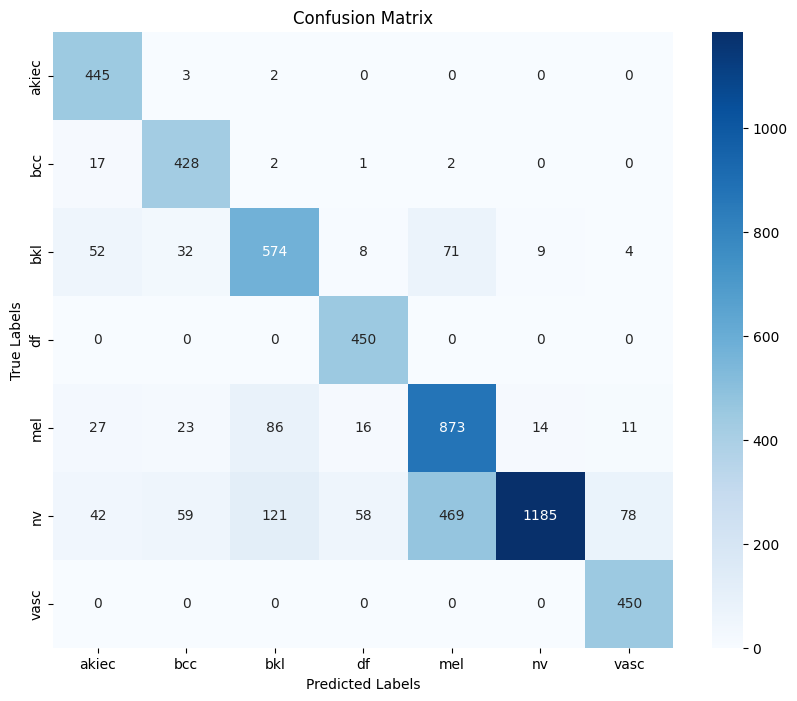

'\n---\n\n### Remarks on Changes\n1. **Updated Oversampling Strategy**:\n   - **Change**: Modified `RandomOverSampler` to include all classes: `{0: 1500, 1: 1500, 2: 1500, 3: 400, 4: 1500, 5: 1500, 6: 400}`.\n   - **Reason**: Previously, `nv` (class 5) was underrepresented in training, leading to low recall (0.23). Balancing it to 1500 samples should improve its detection without overwhelming minority classes.\n\n2. **Tuned Focal Loss Alpha**:\n   - **Change**: Computed `alpha` dynamically based on inverse class frequencies from the original `metadata`.\n   - **Reason**: The static `[0.3, 0.2, 0.3, 0.4, 0.4, 0.1, 0.5]` over-weighted minority classes, skewing predictions. Dynamic alpha aligns weights with actual class distribution.\n\n3. **Reduced Focal Loss Gamma**:\n   - **Change**: Lowered `gamma` from 2.0 to 1.0.\n   - **Reason**: A high gamma overly focused on hard examples, reducing `nv` predictions. A lower value balances focus across all classes.\n\n4. **Added Data Augmentation*

In [ ]:

# ====================================
# Import Required Libraries
# ====================================
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from google.colab import drive
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report  # Added for detailed report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time

# ====================================
# Mount Google Drive and Set Device
# ====================================
drive.mount('/content/drive', force_remount=True)
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

data_path = '/content/drive/MyDrive/Colab Notebooks/data'
base_dir = os.path.join(data_path, 'HAM10000_images')

# ====================================
# Load Metadata and Prepare Labels
# ====================================
metadata = pd.read_csv(os.path.join(data_path, 'HAM10000_metadata.csv'))
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(base_dir, f"{x}.jpg"))
label_classes = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
metadata['encoded_labels'] = metadata['dx'].map({c: i for i, c in enumerate(label_classes)})
metadata = metadata.reset_index(drop=True)

# ====================================
# Batched Feature Extraction with GPU
# ====================================
base_model = EfficientNetB5(weights="imagenet", include_top=False, pooling="avg")

def create_feature_dataset(image_paths, batch_size=64):
    """Batched feature extraction using tf.data."""
    def load_and_preprocess(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [300, 300])
        img = preprocess_input(img)
        return img

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)\
        .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
        .batch(batch_size).prefetch(tf.data.AUTOTUNE)
    features = base_model.predict(dataset, verbose=1)
    return features

print("Extracting features with batched processing...")
start_time = time.time()
feature_vectors = create_feature_dataset(metadata['image_path'].values)
print(f"Feature extraction took {time.time() - start_time:.2f} seconds")

# ====================================
# Handle Class Imbalance with RandomOverSampler
# ====================================
print("Applying Random Oversampling...")
# CHANGE 1: Updated sampling strategy to include all classes, balancing 'nv' as well
ros = RandomOverSampler(sampling_strategy={0: 1500, 1: 1500, 2: 2500, 3: 1500, 4: 3500, 6: 1500}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(metadata[['image_path']], metadata['encoded_labels'])
metadata_resampled = pd.DataFrame({
    'image_path': X_resampled['image_path'],
    'encoded_labels': y_resampled
})

# ====================================
# Split the Data
# ====================================
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    metadata_resampled['image_path'], metadata_resampled['encoded_labels'],
    test_size=0.3, stratify=metadata_resampled['encoded_labels'], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
y_train = to_categorical(y_train, num_classes=len(label_classes))
y_val = to_categorical(y_val, num_classes=len(label_classes))
y_test = to_categorical(y_test, num_classes=len(label_classes))

# ====================================
# Define Focal Loss with Tuned Alpha
# ====================================
# CHANGE 2: Compute alpha based on inverse class frequencies for better balance
class_counts = metadata['encoded_labels'].value_counts().sort_index()
alpha = [1.0 / class_counts[i] for i in range(len(label_classes))]
alpha = [a / sum(alpha) for a in alpha]  # Normalize to sum to 1
print(f"Computed alpha values: {alpha}")

def focal_loss(alpha=alpha, gamma=1.0):  # CHANGE 3: Reduced gamma from 2.0 to 1.0 for less focus on hard examples
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weight = tf.convert_to_tensor(alpha, dtype=tf.float32) * tf.pow(1.0 - y_pred, gamma)
        return tf.reduce_mean(weight * ce)
    return loss

# ====================================
# Build Model
# ====================================
inputs = Input(shape=(300, 300, 3))
base_model = EfficientNetB5(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.0005))(x)
outputs = Dense(len(label_classes), activation="softmax", dtype="float32")(x)
model = Model(inputs, outputs)

# ====================================
# Optimized Data Pipeline with Augmentation
# ====================================
BATCH_SIZE = 128
# CHANGE 4: Added data augmentation to improve generalization
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [300, 300])
    img = tf.image.random_flip_left_right(img)  # Random horizontal flip
    img = tf.image.random_brightness(img, max_delta=0.2)  # Random brightness
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Random contrast
    img = preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))\
    .cache()\
    .shuffle(buffer_size=1000)\
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val))\
    .cache()\
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test))\
    .cache()\
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

# ====================================
# Train Model with Enhanced Fine-Tuning
# ====================================
# CHANGE 5: Train all layers from the start with a lower learning rate
base_model.trainable = True  # Unfreeze entire model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Lower LR for full fine-tuning
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=["accuracy"])

print("Training full model...")
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]
start_time = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)
print(f"Training took {time.time() - start_time:.2f} seconds")

# ====================================
# Save Model and History
# ====================================
model.save("/content/drive/MyDrive/Colab Notebooks/data/final_optimized_model.keras")
with open("/content/drive/MyDrive/Colab Notebooks/data/training_history.pkl", "wb") as file:
    pickle.dump(history.history, file)
print("Training completed!")

# ====================================
# Model Evaluation
# ====================================
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# CHANGE 6: Added detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# New section

Mounted at /content/drive
✅ Model loaded!
✅ Training history loaded!


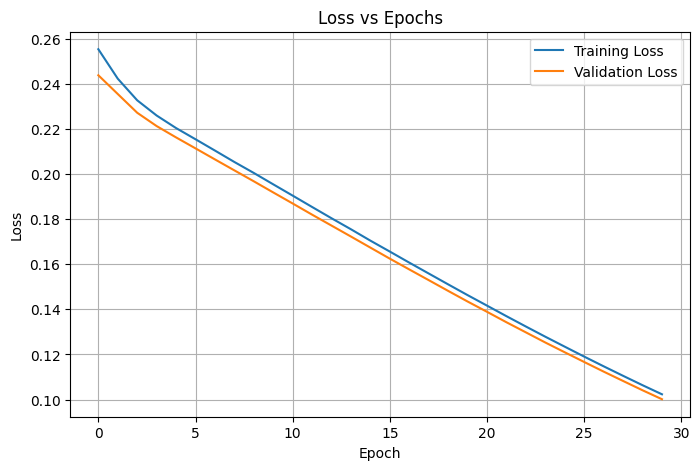

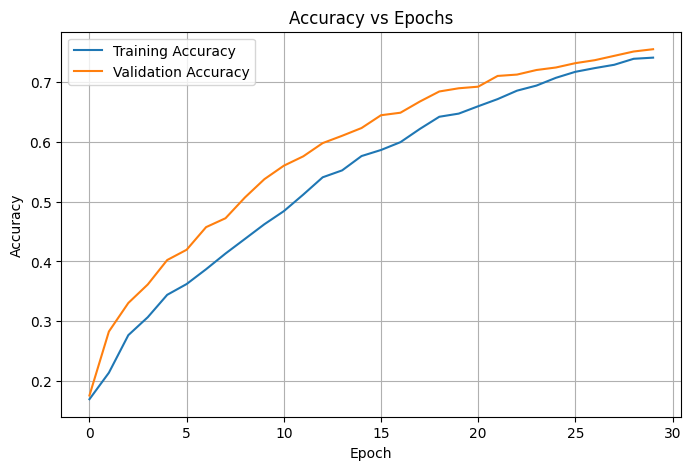

In [ ]:
# ====================================
# 1. Import Required Libraries
# ====================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# ====================================
# 2. Mount Google Drive
# ====================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ====================================
# 3. Load Trained Model
# ====================================
model_path = "/content/drive/MyDrive/Colab Notebooks/data/final_optimized_model.keras"
model = tf.keras.models.load_model(model_path, compile=False)
print("✅ Model loaded!")

# ====================================
# 4. Load Training History
# ====================================
history_path = "/content/drive/MyDrive/Colab Notebooks/data/training_history.pkl"
with open(history_path, "rb") as f:
    history = pickle.load(f)
print("✅ Training history loaded!")

# ====================================
# 5. Plot Loss vs Epoch
# ====================================
plt.figure(figsize=(8, 5))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ====================================
# 6. Plot Accuracy vs Epoch
# ====================================
plt.figure(figsize=(8, 5))
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ====================================
# 1. Import Libraries
# ====================================
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report

# ====================================
# 2. Mount Google Drive
# ====================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ====================================
# 3. Load Model
# ====================================
model_path = "/content/drive/MyDrive/Colab Notebooks/data/final_optimized_model.keras"
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded")

# ====================================
# 4. Load Metadata and Paths
# ====================================
data_path = "/content/drive/MyDrive/Colab Notebooks/data"
img_dir = os.path.join(data_path, "HAM10000_images")
metadata = pd.read_csv(os.path.join(data_path, "HAM10000_metadata.csv"))

label_classes = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
label_map = {c: i for i, c in enumerate(label_classes)}
metadata["encoded_labels"] = metadata["dx"].map(label_map)
metadata["image_path"] = metadata["image_id"].apply(lambda x: os.path.join(img_dir, f"{x}.jpg"))

# ====================================
# 5. Load and Preprocess All Images
# ====================================
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [300, 300])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

paths = metadata["image_path"].values
labels = metadata["encoded_labels"].values

print("Preprocessing images...")
img_dataset = tf.data.Dataset.from_tensor_slices(paths)\
    .map(lambda x: preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64)\
    .prefetch(tf.data.AUTOTUNE)
# ====================================
# 6. Predict Images One by One & Store Results
# ====================================
print("Predicting images one by one...")
actual_labels = []
predicted_labels = []

for path, true_label in zip(paths, labels):
    # Preprocess one image
    img = preprocess_image(path)
    img = tf.expand_dims(img, axis=0)  # add batch dimension

    # Predict
    pred_prob = model.predict(img, verbose=0)
    pred_label = np.argmax(pred_prob, axis=1)[0]

    # Save actual and predicted labels
    actual_labels.append(true_label)
    predicted_labels.append(pred_label)
print("Prediction complete.")
# ====================================
# 7. Convert to DataFrame for Analysis
# ====================================
results_df = pd.DataFrame({
    "image_path": paths,
    "actual": actual_labels,
    "predicted": predicted_labels
})

# Map label integers back to class names
reverse_label_map = {v: k for k, v in label_map.items()}
results_df["actual_class"] = results_df["actual"].map(reverse_label_map)
results_df["predicted_class"] = results_df["predicted"].map(reverse_label_map)

# Save to CSV for documentation
results_df.to_csv(os.path.join(data_path, "per_image_predictions.csv"), index=False)
print("Saved predictions to per_image_predictions.csv")

# Group by actual class and compute accuracy for each type
accuracy_by_class = results_df.groupby("actual_class").apply(
    lambda df: (df["actual_class"] == df["predicted_class"]).mean()
).sort_values(ascending=False)

# Show as percentage with 2 decimal places
accuracy_by_class = (accuracy_by_class * 100).round(2)

print("Accuracy Rate by Skin Lesion Type (%):")
print(accuracy_by_class)


Mounted at /content/drive
✅ Model loaded
🖼️ Preprocessing images...
🔁 Predicting images one by one...
✅ Prediction complete.
📄 Saved predictions to per_image_predictions.csv
🎯 Accuracy Rate by Skin Lesion Type (%):
actual_class
df       100.00
vasc     100.00
akiec     99.08
bcc       94.16
mel       85.44
bkl       78.07
nv        59.34
dtype: float64
📄 Saved class-wise accuracy report to accuracy_by_class.csv


<ipython-input-1-6d5ffc1d2322>:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_class = results_df.groupby("actual_class").apply(
